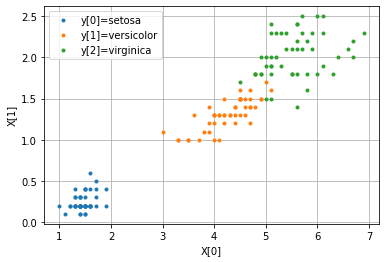

In [2]:
# carregando dataset
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt 
dataset = load_iris()
X, y = dataset.data[:, 2:], dataset.target

for value in sorted(set(y)):
        plt.plot(X[:, 0][y==value], X[:, 1][y==value], '.', label=f"y[{value}]={dataset.target_names[value]}")
plt.grid()
plt.legend()
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.show()

In [3]:
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
# calculos de impurities

def gini(proportions):    
    return 1 - sum(proportions**2)

def entropy(proportions):
    return sum(-proportions * np.log2(proportions))

def misclassification(proportions):
    return 1 - sum(proportions**1)

def impurity(y, method):
    labels = list(set(y))
    labels.sort()
    proportions = np.zeros((len(labels)))
    for i, k in enumerate(labels):
        proportions[i] = sum(y==k)/len(y)

    if method is 'gini':
        return gini(proportions)
    if method is 'entropy':
        return entropy(proportions)
    if method is 'misclassification':
        return misclassification(proportions)

def impurityByValue(x, y, value, method):
    # maiores que o valor
    higher = x > value
    impurity_higher = impurity(y[higher], method)
    ratio_higher = sum(higher)/len(y)

    # iguais ao valor
    equal = x == value
    impurity_equal = impurity(y[equal], method)
    ratio_equal = sum(equal)/len(y)
    
    # menores que o valor
    lower = x < value
    impurity_lower = impurity(y[lower], method)
    ratio_lower = sum(lower)/len(y)

    # total
    impurity_total = ratio_lower*impurity_lower + ratio_higher*impurity_higher + ratio_equal*impurity_equal
    return impurity_total, impurity_higher, impurity_lower
    
def minimalImpurity(X, y):
    impurities = []
    feature_values = []
    # para cada caracteristica
    for i in range(X.shape[1]):
        feature = X[:, i] # pega todas a linhas daquela caracteristica 
        values = sorted(list(set(feature))) # ordena para garantir a ordem
        for value in values: # para cada valor
            feature_values.append([i, value]) # adiciona na lista de caracteristicas 
            impurityValue = impurityByValue(feature, y, value) # avaia o valor da impureza
            impurities.append(impurityValue) # adiciona este valor na lista de impurezas
    feature_values = np.array(feature_values) # convete para numpy array
    impurities = np.array(impurities) # converte para numpy array
    least_impurity = np.argmin(impurities,0)[0] # menor impureza
    feature, value = feature_values[least_impurity] # obtém a caracteristica e o valor da que tem a menor impureza
    return impurities[least_impurity], int(feature), value # retona as impurezas, o index da caracteristica e o valor

def mostCommon(y):
    return Counter(y.flat).most_common(1)[0][0]

def bestFeature(X, y, method):
    impurities = []
    values = []

    for feature in range(X.shape[1]):
        value, impurityValue = bestValue(X[:, feature],y, method)
        impurities.append(impurityValue)
        values.append(value)
    impurities = np.array(impurities)
    feature = np.argmin(impurities)
    return feature, values[feature], impurities[feature]

def bestValue(x, y, method):
    result = None
    impurities = []
    xmax = np.max(x)
    xmin = np.min(x)
    i=0
    # rodar pelo menos 5 vezes
    while i<5:
        # procura os index de xmax e xin
        a = np.argwhere(x<=xmin)[0][0]
        b = np.argwhere(x>=xmax)[0][0]

        # inverte, caso o maior seja antes do menor
        if (a>b):
            c = int(a)
            a = int(b)
            b = int(c)

        # quando não iguais, calcula a mediana com os valores do intervalo
        if (a!=b):
            value = np.median(x[a:b])
        # quando é igual, é o proprio valor x[a] ou x[b]
        else:
            value = x[a]
        # calcula a impureza
        impurity_total, impurity_higher, impurity_lower = impurityByValue(x, y, value, method)

        # print(f"x[{a}]={xmin}, x[{b}]={xmax}, value={value}, impurity={impurity_total}, h={impurity_higher}, l={impurity_lower}") 
        impurities.append([impurity_total, value])

        if impurity_higher ==0 or impurity_lower ==0:
            break

        if impurity_higher <= impurity_lower:
            xmin = value
        else:
            xmax = value        
        i+=1
    impurities = np.array(impurities) # converte para numpy array
    index = np.argmin(impurities,0)[0] # menor impureza
    least_impurity, result = impurities[index][0],  impurities[index][1]
    return result, least_impurity

bestValue(X[:, 0], y, 'gini')

(4.2, 0.4173411129932869)

In [4]:
class Tree(BaseEstimator, ClassifierMixin):
    def __init__(self, method = 'gini'):
        self.method=method
    
    def fit(self, X, y):
        # print('--fit--')
        self.feature, self.value, self.impurity = bestFeature(X, y, self.method)
        self.value = np.mean(X[:, self.feature])
        higher = X[:, self.feature] > self.value
        if sum(higher)>0 and sum(~higher)>0:
            self.higher = Tree()
            self.higher.fit(X[higher,:], y[higher])
            self.lower = Tree()
            self.lower.fit(X[~higher,:], y[~higher])
        else:
            self.answer = mostCommon(y)

    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'answer'):
            y[:] = self.answer
        else: 
            higher = X[:, self.feature] > self.value
            y[higher] = self.higher.predict(X[higher, :])
            y[~higher] = self.lower.predict(X[~higher, :])
        return y

In [5]:
from sklearn.metrics import accuracy_score
model = Tree(method='gini')
model.fit(X, y)
ypred = model.predict(X)
accuracy_score(y, ypred)

0.9933333333333333

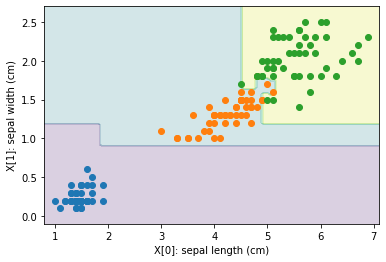

In [6]:
import matplotlib.pyplot as plt 
import numpy as np 

def plot_region(model, X, y):
    model.fit(X, y)
    X0, X1 = X[:, 0], X[:,1]
    x0s = np.linspace(np.min(X0)-0.2, np.max(X0)+0.2,100)
    x1s = np.linspace(np.min(X1)-0.2, np.max(X1)+0.2,100)

    x0, x1 = np.meshgrid(x0s, x1s)
    x_decision = np.c_[x0.ravel(), x1.ravel()]
    yprediction = model.predict(x_decision)

    plt.contourf(x0, x1, yprediction.reshape(x0.shape), alpha=0.2)
    for value in set(y):
        plt.plot(X0[y==value], X1[y==value], 'o')
    plt.xlabel(f"X[0]: {dataset.feature_names[0]}")
    plt.ylabel(f"X[1]: {dataset.feature_names[1]}")
    plt.show()

plot_region(Tree(method='gini'), X, y)

In [7]:
from sklearn.metrics import accuracy_score
model = Tree(method='gini')
model.fit(X, y)
ypred = model.predict(X)
accuracy_score(y, ypred)

0.9933333333333333

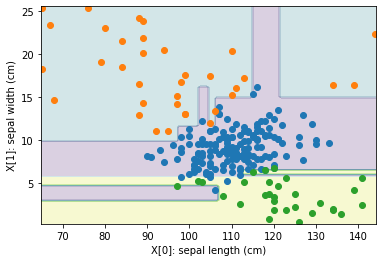

In [8]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

#  thyroid-new
dataset1 = fetch_openml(data_id='40682')
X1, y1 = dataset1.data[:,:2], np.array(dataset1.target).astype(np.int)
plot_region(Tree(method='gini'), X1, y1)



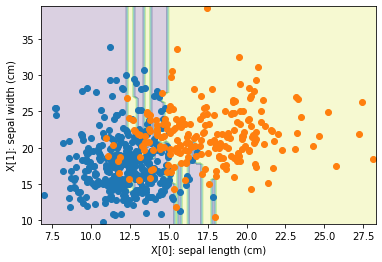

In [20]:
# blood-transfusion-service-center
dataset2 = fetch_openml(data_id='1510')
X2, y2 = dataset2.data[:,:2], np.array(dataset2.target).astype(np.int)
plot_region(Tree(method='gini'), X2, y2)

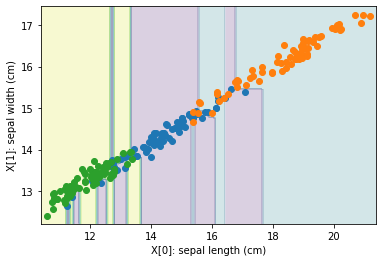

In [18]:
#  Engine1
dataset3 = fetch_openml(data_id='1500')
X3, y3 = dataset3.data[:,:2], np.array(dataset3.target).astype(np.int)
plot_region(Tree(method='gini'), X3, y3)

In [21]:
from sklearn.model_selection import cross_validate

scores = cross_validate(Tree(method='gini'),X1, y1)
mean_score = np.mean(scores['test_score'])
print(f"1 - score: {mean_score*100:.2f}%")

scores = cross_validate(Tree(method='gini'),X2, y2)
mean_score = np.mean(scores['test_score'])
print(f"2 - score: {mean_score*100:.2f}%")

scores = cross_validate(Tree(method='gini'),X3, y3)
mean_score = np.mean(scores['test_score'])
print(f"3 - score: {mean_score*100:.2f}%")

1 - score: 91.63%
2 - score: 85.41%
3 - score: 83.81%
